In [5]:
import torch
import torch.nn as nn
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import sklearn.metrics as skmetrics


from network import DeepNetwork

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = DeepNetwork()
net.to(device)
print("Model archticture: ", net)

Model archticture:  DeepNetwork(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=7, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
#FER2013
names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
class FerDataset(Dataset):
    def __init__(self, csv_file, img_dir, datatype, transform):
        self.csv_file = pd.read_csv(csv_file)
        self.lables = self.csv_file['emotion']
        self.img_dir = img_dir
        self.transform = transform
        self.datatype = datatype

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = Image.open(self.img_dir + self.datatype + str(idx) + '.jpg')
        # lables = np.array([0,0,0,0,0,0,0])
        # lables[self.lables[idx]] = 1
        lables = np.array(self.lables[idx])
        lables = torch.from_numpy(lables).long()


        if self.transform :
            img = self.transform(img)
        return img,lables

In [ ]:
traincsv_file = 'data/train.csv'
validationcsv_file = 'data/test.csv'
train_img_dir = 'data/train/'
validation_img_dir = 'data/test/'


transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
train_dataset= FerDataset(
	csv_file=traincsv_file, 
	img_dir = train_img_dir, 
	datatype = 'train', 
	transform = transformation
)
validation_dataset= FerDataset(
	csv_file=validationcsv_file, 
	img_dir = validation_img_dir, 
	datatype = 'test', 
	transform = transformation
)

In [7]:
#CK+
names = ['anger','contempt','disgust','fear','happy','sadness','surprise']
class CkDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.transform = transform
        self.x = []
        self.y = []
        for label in os.listdir(img_dir):
            if(label == '.DS_Store'):
                continue
            for img in os.listdir(img_dir+'/'+label):
                img = Image.open(self.img_dir + '/' +label +'/'+img)
                if self.transform :
                    img = self.transform(img)
                self.x.append(img)
                self.y.append(names.index(label))

    def __len__(self):
        return self.y.__len__()

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

In [8]:
transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
ck_dataset = CkDataset('./CK+48',transform=transformation)

train_size = int(0.8 * len(ck_dataset))
test_size = len(ck_dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(ck_dataset, [train_size, test_size])

In [9]:

batchsize = 128

train_loader= DataLoader(
	train_dataset,
	batch_size=batchsize,
	shuffle = True,
	num_workers=0
)
val_loader=   DataLoader(
	validation_dataset,
	batch_size=batchsize,
	shuffle = True,
	num_workers=0
)

conf_mat = np.zeros(shape=(7,7))


In [10]:
def Train(epochs, train_loader, val_loader, criterion, optmizer, device):
    '''
    Training Loop
    '''
    metrics = {}

    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0

        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)

        #validate the model#
        net.eval()
        predlist=torch.zeros(0,dtype=torch.long, device=device)
        lbllist=torch.zeros(0,dtype=torch.long, device=device)

        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)
            # print(type(val_preds), type(val_preds[0]))
            predlist = torch.cat([predlist, val_preds.flatten()])
            lbllist = torch.cat([lbllist, labels.data.flatten()])

        train_loss = train_loss/len(train_dataset)
        train_acc = train_correct.double() / len(train_dataset)
        validation_loss =  validation_loss / len(validation_dataset)
        val_acc = val_correct.double() / len(validation_dataset)
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))

    torch.save(net.state_dict(),'deep_emotion-{}-{}-{}.pt'.format(epochs,batchsize,lr))
    print("===================================Training Finished===================================")


    def mapFun(i):
        return lambda x : int(x==i)
    fpr = []
    tpr = []
    for i in range(7):
        f, t, _ = skmetrics.roc_curve(
            list(map(mapFun(i), lbllist.tolist())), 
            list(map(mapFun(i), predlist.tolist()))
        )
        fpr.append(f)
        tpr.append(t)

    conf_mat = np.zeros(shape=(7,7))
    for i in range(len(predlist)):
        # print(type(lbllist[i].item()))
        conf_mat[lbllist[i].item()][predlist[i].item()] += 1

    
    metrics['f1_score'] = skmetrics.f1_score(lbllist.tolist(), predlist.tolist(), average=None)
    # metrics['y_true'] = lbllist.tolist()
    # metrics['y_pred'] = predlist.tolist()
    metrics['conf_mat'] = conf_mat
    metrics['fpr'] = fpr
    metrics['tpr'] = tpr

    return metrics


In [11]:
epochs = 10
lr = 0.005
criterion= nn.CrossEntropyLoss()
optmizer= optim.Adam(net.parameters(),lr= lr)

metrics = Train(
	epochs, 
	train_loader, 
	val_loader, 
	criterion, 
	optmizer, 
	device
)

print(metrics['conf_mat'])

===================================Start Training===================================
Epoch: 1 	Training Loss: 0.01603159 	Validation Loss 0.01973224 	Training Acuuarcy 29.209% 	Validation Acuuarcy 15.736%
Epoch: 2 	Training Loss: 0.01385393 	Validation Loss 0.01886183 	Training Acuuarcy 43.878% 	Validation Acuuarcy 30.964%
Epoch: 3 	Training Loss: 0.01205454 	Validation Loss 0.01805844 	Training Acuuarcy 50.765% 	Validation Acuuarcy 37.056%
Epoch: 4 	Training Loss: 0.01081755 	Validation Loss 0.01617688 	Training Acuuarcy 56.122% 	Validation Acuuarcy 46.701%
Epoch: 5 	Training Loss: 0.01012538 	Validation Loss 0.01418355 	Training Acuuarcy 59.821% 	Validation Acuuarcy 53.299%
Epoch: 6 	Training Loss: 0.00870394 	Validation Loss 0.01172959 	Training Acuuarcy 64.541% 	Validation Acuuarcy 65.482%
Epoch: 7 	Training Loss: 0.00929604 	Validation Loss 0.01307464 	Training Acuuarcy 67.092% 	Validation Acuuarcy 52.792%
Epoch: 8 	Training Loss: 0.00816502 	Validation Loss 0.01705247 	Training A

In [12]:
from prettytable import PrettyTable

table = PrettyTable(['Class','F1 Score'])
for i in range(7):
	table.add_row([
		names[i], 
		"{:.3f}".format(metrics['f1_score'][i])
	])

table


Class,F1 Score
anger,0.620
contempt,0.190
disgust,0.729
fear,0.143
happy,0.725
sadness,0.000
surprise,0.804


Text(0, 0.5, 'True Positive Rate')

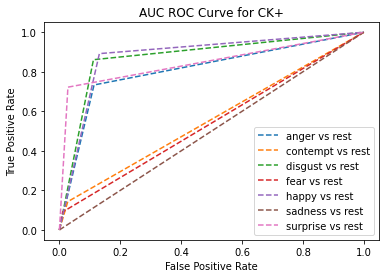

In [13]:
fpr = metrics['fpr']
tpr = metrics['tpr']

fig = plt.figure()

for i in range(7):
	plt.plot(fpr[i], tpr[i], label=names[i]+' vs rest', linestyle='--')
plt.legend()
plt.title("AUC ROC Curve for CK+")
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")


In [14]:
img =  np.array([[10,100,200],
	[0, 255, 122],
	[23, 20, 102]])
print(img)
print(img/255)
print((img/255).flatten())

[[ 10 100 200]
 [  0 255 122]
 [ 23  20 102]]
[[0.03921569 0.39215686 0.78431373]
 [0.         1.         0.47843137]
 [0.09019608 0.07843137 0.4       ]]
[0.03921569 0.39215686 0.78431373 0.         1.         0.47843137
 0.09019608 0.07843137 0.4       ]


In [15]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(net)

+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
|      conv1.weight     |     90     |
|       conv1.bias      |     10     |
|      conv2.weight     |    900     |
|       conv2.bias      |     10     |
|      conv3.weight     |    900     |
|       conv3.bias      |     10     |
|      conv4.weight     |    900     |
|       conv4.bias      |     10     |
|      norm.weight      |     10     |
|       norm.bias       |     10     |
|       fc1.weight      |   40500    |
|        fc1.bias       |     50     |
|       fc2.weight      |    350     |
|        fc2.bias       |     7      |
| localization.0.weight |    392     |
|  localization.0.bias  |     8      |
| localization.3.weight |    2000    |
|  localization.3.bias  |     10     |
|    fc_loc.0.weight    |   20480    |
|     fc_loc.0.bias     |     32     |
|    fc_loc.2.weight    |    192     |
|     fc_loc.2.bias     |     6      |
+-----------------------+

66877

<AxesSubplot:>

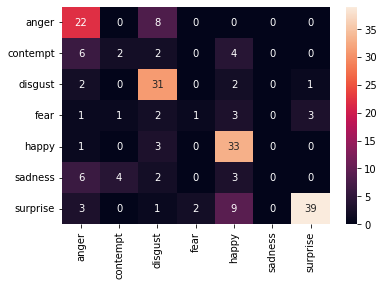

In [17]:
import seaborn as sns
sns.heatmap(metrics['conf_mat'], annot=True, xticklabels=names, yticklabels=names)

array([0.     , 0.00625, 1.     ])